# Applying regression models to new target variable - total amount raised (usdm)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import time
from datetime import date

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
data_for_processing = pd.read_csv('data_post_clean.csv', index_col=0)

In [40]:
data_for_processing.shape

(269, 17)

In [4]:
data_cat = ['token_type','registration_country','legal_structure','industry', 'vc_count']

data_dummy = ['is_active', 'celebrity_endorsement', 'ico_successful', 'investors_have_governance_rights', 'kyc/aml_procedure', 'legal_form_and_jurisdiction_known', 'use_of_proceeds_mentioned']

data_num = ['length_of_crowdsale_(calendar_days,_actual)', 'team_size', 'time_to_listing_(calendar_days)', 'whitepaper_page_count']

In [5]:
def X_y_split(X,y):
    ## Split the data into a training set and a test set.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)

    # split numericals & categoricals
    X_train_num = X_train[data_num]
    X_test_num = X_test[data_num]
    
    X_train_cat = X_train[data_cat]
    X_test_cat = X_test[data_cat]
    
    ## Scale the features either by using normalizer or a standard scaler.
        
    # fit and transform scaling numericals
    minmax = MinMaxScaler().fit(X_train_num) 
    
    X_train_norm = minmax.transform(X_train_num)
    X_test_norm = minmax.transform(X_test_num)

    # convert to dataframe again
    X_train_norm = pd.DataFrame(X_train_norm,columns=X_train_num.columns).reset_index(drop=True)
    X_test_norm = pd.DataFrame(X_test_norm,columns=X_test_num.columns).reset_index(drop=True)
    
    ## Encode the categorical features using One-Hot Encoding
    
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)
    
    # fit and transform encoding categoricals
    onehot = OneHotEncoder(drop='first', handle_unknown='ignore').fit(X_train_cat) 
    
    cols = onehot.get_feature_names_out(input_features=X_train_cat.columns)

    X_train_enc = onehot.transform(X_train_cat).toarray()
    X_test_enc = onehot.transform(X_test_cat).toarray()
    
    # convert to dataframe again
    X_train_enc = pd.DataFrame(X_train_enc, columns=cols).reset_index(drop=True)
    X_test_enc = pd.DataFrame(X_test_enc, columns=cols).reset_index(drop=True)
    
    # ready to fit the model

    data_dummy_train = X_train[data_dummy].reset_index(drop=True)
    data_dummy_test = X_test[data_dummy].reset_index(drop=True)

    X_train_ready = pd.concat([X_train_norm,X_train_enc,data_dummy_train],axis=1)
    X_test_ready = pd.concat([X_test_norm,X_test_enc,data_dummy_test],axis=1)
    
    return X_train_ready, X_test_ready, y_train, y_test

In [6]:
X = data_for_processing.drop(['total_amount_raised_(usdm)'], axis=1)
y = data_for_processing[['total_amount_raised_(usdm)']]

X_train_ready, X_test_ready, y_train, y_test = X_y_split(X,y)

(201, 16)
(68, 16)
(201, 1)
(68, 1)


In [7]:
def models_automation(models, X_tr, y_tr, X_te, y_te):
    for model in models:
        model.fit(X_tr, y_tr)
        print(f"{model.__class__.__name__}: Train -> {model.score(X_tr, y_tr)}, Test -> {model.score(X_te, y_te)}")

In [8]:
models = [LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor(), KNeighborsRegressor()]

models_automation(models, X_train_ready, y_train, X_test_ready, y_test)

LinearRegression: Train -> 0.44128999617335307, Test -> 0.06173688850181447
RandomForestRegressor: Train -> 0.8625321065468124, Test -> 0.12755855632693358
DecisionTreeRegressor: Train -> 1.0, Test -> -1.199574774972484
KNeighborsRegressor: Train -> 0.3280738304175568, Test -> 0.10629506863566773


## Prediction models are pointless here. Let's look at regression results instead

In [73]:
import statsmodels.api as sm

In [74]:
data_for_ols = pd.read_csv('data_post_clean.csv', index_col=0)

In [75]:
data_cat = ['token_type','registration_country','legal_structure','industry', 'vc_count']

data_dummy = ['is_active', 'celebrity_endorsement', 'ico_successful', 'investors_have_governance_rights', 'kyc/aml_procedure', 'legal_form_and_jurisdiction_known', 'use_of_proceeds_mentioned']

data_num = ['length_of_crowdsale_(calendar_days,_actual)', 'team_size', 'time_to_listing_(calendar_days)', 'whitepaper_page_count']

In [76]:
def clean(X,y):

    # split numericals & categoricals
    X_num = X[data_num]
    X_cat = X[data_cat]

    ## Scale the features either by using normalizer or a standard scaler.
        
    # fit and transform scaling numericals
    minmax = MinMaxScaler().fit(X_num) 
    X_norm = minmax.transform(X_num)

    # convert to dataframe again
    X_norm = pd.DataFrame(X_norm,columns=X_num.columns).reset_index(drop=True)
    
    ## Encode the categorical features using One-Hot Encoding
    
    X_cat = X_cat.astype(str)

    # fit and transform encoding categoricals
    onehot = OneHotEncoder(drop='first', handle_unknown='ignore').fit(X_cat) 
    
    cols = onehot.get_feature_names_out(input_features=X_cat.columns)

    X_enc = onehot.transform(X_cat).toarray()
    
    # convert to dataframe again
    X_enc = pd.DataFrame(X_enc, columns=cols).reset_index(drop=True)
    
    # ready to fit the model

    data_dummy_added = X[data_dummy].reset_index(drop=True)
    X_ready = pd.concat([X_norm,X_enc,data_dummy_added],axis=1)
    
    return X_ready, y

In [77]:
X = data_for_ols.drop(['total_amount_raised_(usdm)'], axis=1)
y = data_for_ols[['total_amount_raised_(usdm)']]

X_clean, y = clean(X,y)

In [78]:
X_added_constant = sm.add_constant(X_clean)
model = sm.OLS(y, X_added_constant).fit()

In [79]:
pred = model.predict(X_added_constant)

In [80]:
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     total_amount_raised_(usdm)   R-squared:                       0.395
Model:                                    OLS   Adj. R-squared:                  0.193
Method:                         Least Squares   F-statistic:                     1.958
Date:                        Thu, 03 Nov 2022   Prob (F-statistic):           0.000182
Time:                                17:38:56   Log-Likelihood:                -1202.9
No. Observations:                         269   AIC:                             2542.
Df Residuals:                             201   BIC:                             2786.
Df Model:                                  67                                         
Covariance Type:                    nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [81]:
OLSresult = pd.DataFrame(model.summary2().tables[1])

# OLSresult

In [82]:
significant_features = list(OLSresult[OLSresult['P>|t|']<=0.05].index)[0:]

significant_features

['team_size', 'vc_count_2']

In [83]:
OLSresult[OLSresult['P>|t|']<=0.05]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
team_size,40.931012,15.580577,2.627054,0.009277,10.208661,71.653363
vc_count_2,30.779204,6.885591,4.470089,0.000013,17.201945,44.356463


Text(0, 0.5, 'total amount raised in USDm (predicted)')

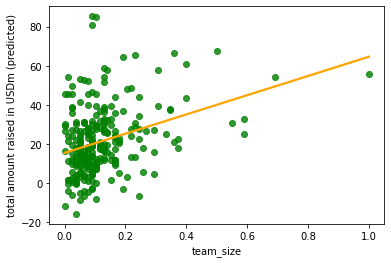

In [85]:
sns.regplot(x=X_clean['team_size'], y=pred, ci=None, scatter_kws={'color': 'green'}, line_kws={'color': 'orange'})
plt.xlabel('team_size')
plt.ylabel('total amount raised in USDm (predicted)')

Text(0, 0.5, 'total amount raised in USDm (predicted)')

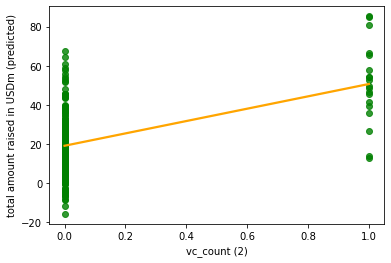

In [84]:
sns.regplot(x=X_clean['vc_count_2'], y=pred, ci=None, scatter_kws={'color': 'green'}, line_kws={'color': 'orange'})
plt.xlabel('vc_count (2)')
plt.ylabel('total amount raised in USDm (predicted)')

## Plotting some variables for my presentation (the pre-processed data regplots)

In [ ]:
import seaborn as sns

<AxesSubplot:xlabel='vc_count', ylabel='total_amount_raised_(usdm)'>

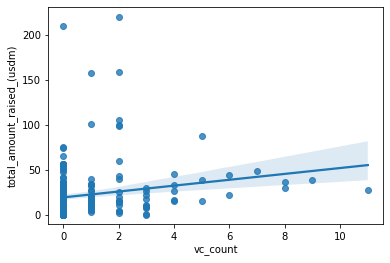

In [24]:
# Pre-data processing:

sns.regplot(x='vc_count', y='total_amount_raised_(usdm)', data=data_for_processing)

<AxesSubplot:xlabel='team_size', ylabel='total_amount_raised_(usdm)'>

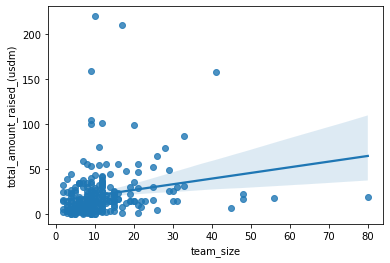

In [23]:
sns.regplot(x='team_size', y='total_amount_raised_(usdm)', data=data_for_processing)

<AxesSubplot:xlabel='length_of_crowdsale_(calendar_days,_actual)', ylabel='total_amount_raised_(usdm)'>

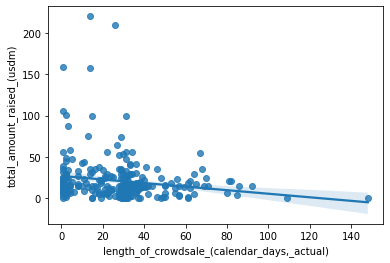

In [98]:
sns.regplot(x='length_of_crowdsale_(calendar_days,_actual)', y='total_amount_raised_(usdm)', data=data_for_processing) 

## Random Forest Regression

In [ ]:
RFR = RandomForestRegressor(max_depth=4)

RFR.fit(X_train_ready, y_train)

In [57]:
print("test data score was: ",RFR.score(X_test_ready, y_test))
print("train data score was: ",RFR.score(X_train_ready, y_train))

test data score was:  0.20488693453874252
train data score was:  0.7052658080731727


In [58]:
# We see the modle results for test data are terrible again. So let's look at the full dataset

RFR_2 = RandomForestRegressor(max_depth=4)

RFR_2.fit(X_clean, y)

RandomForestRegressor(max_depth=4)

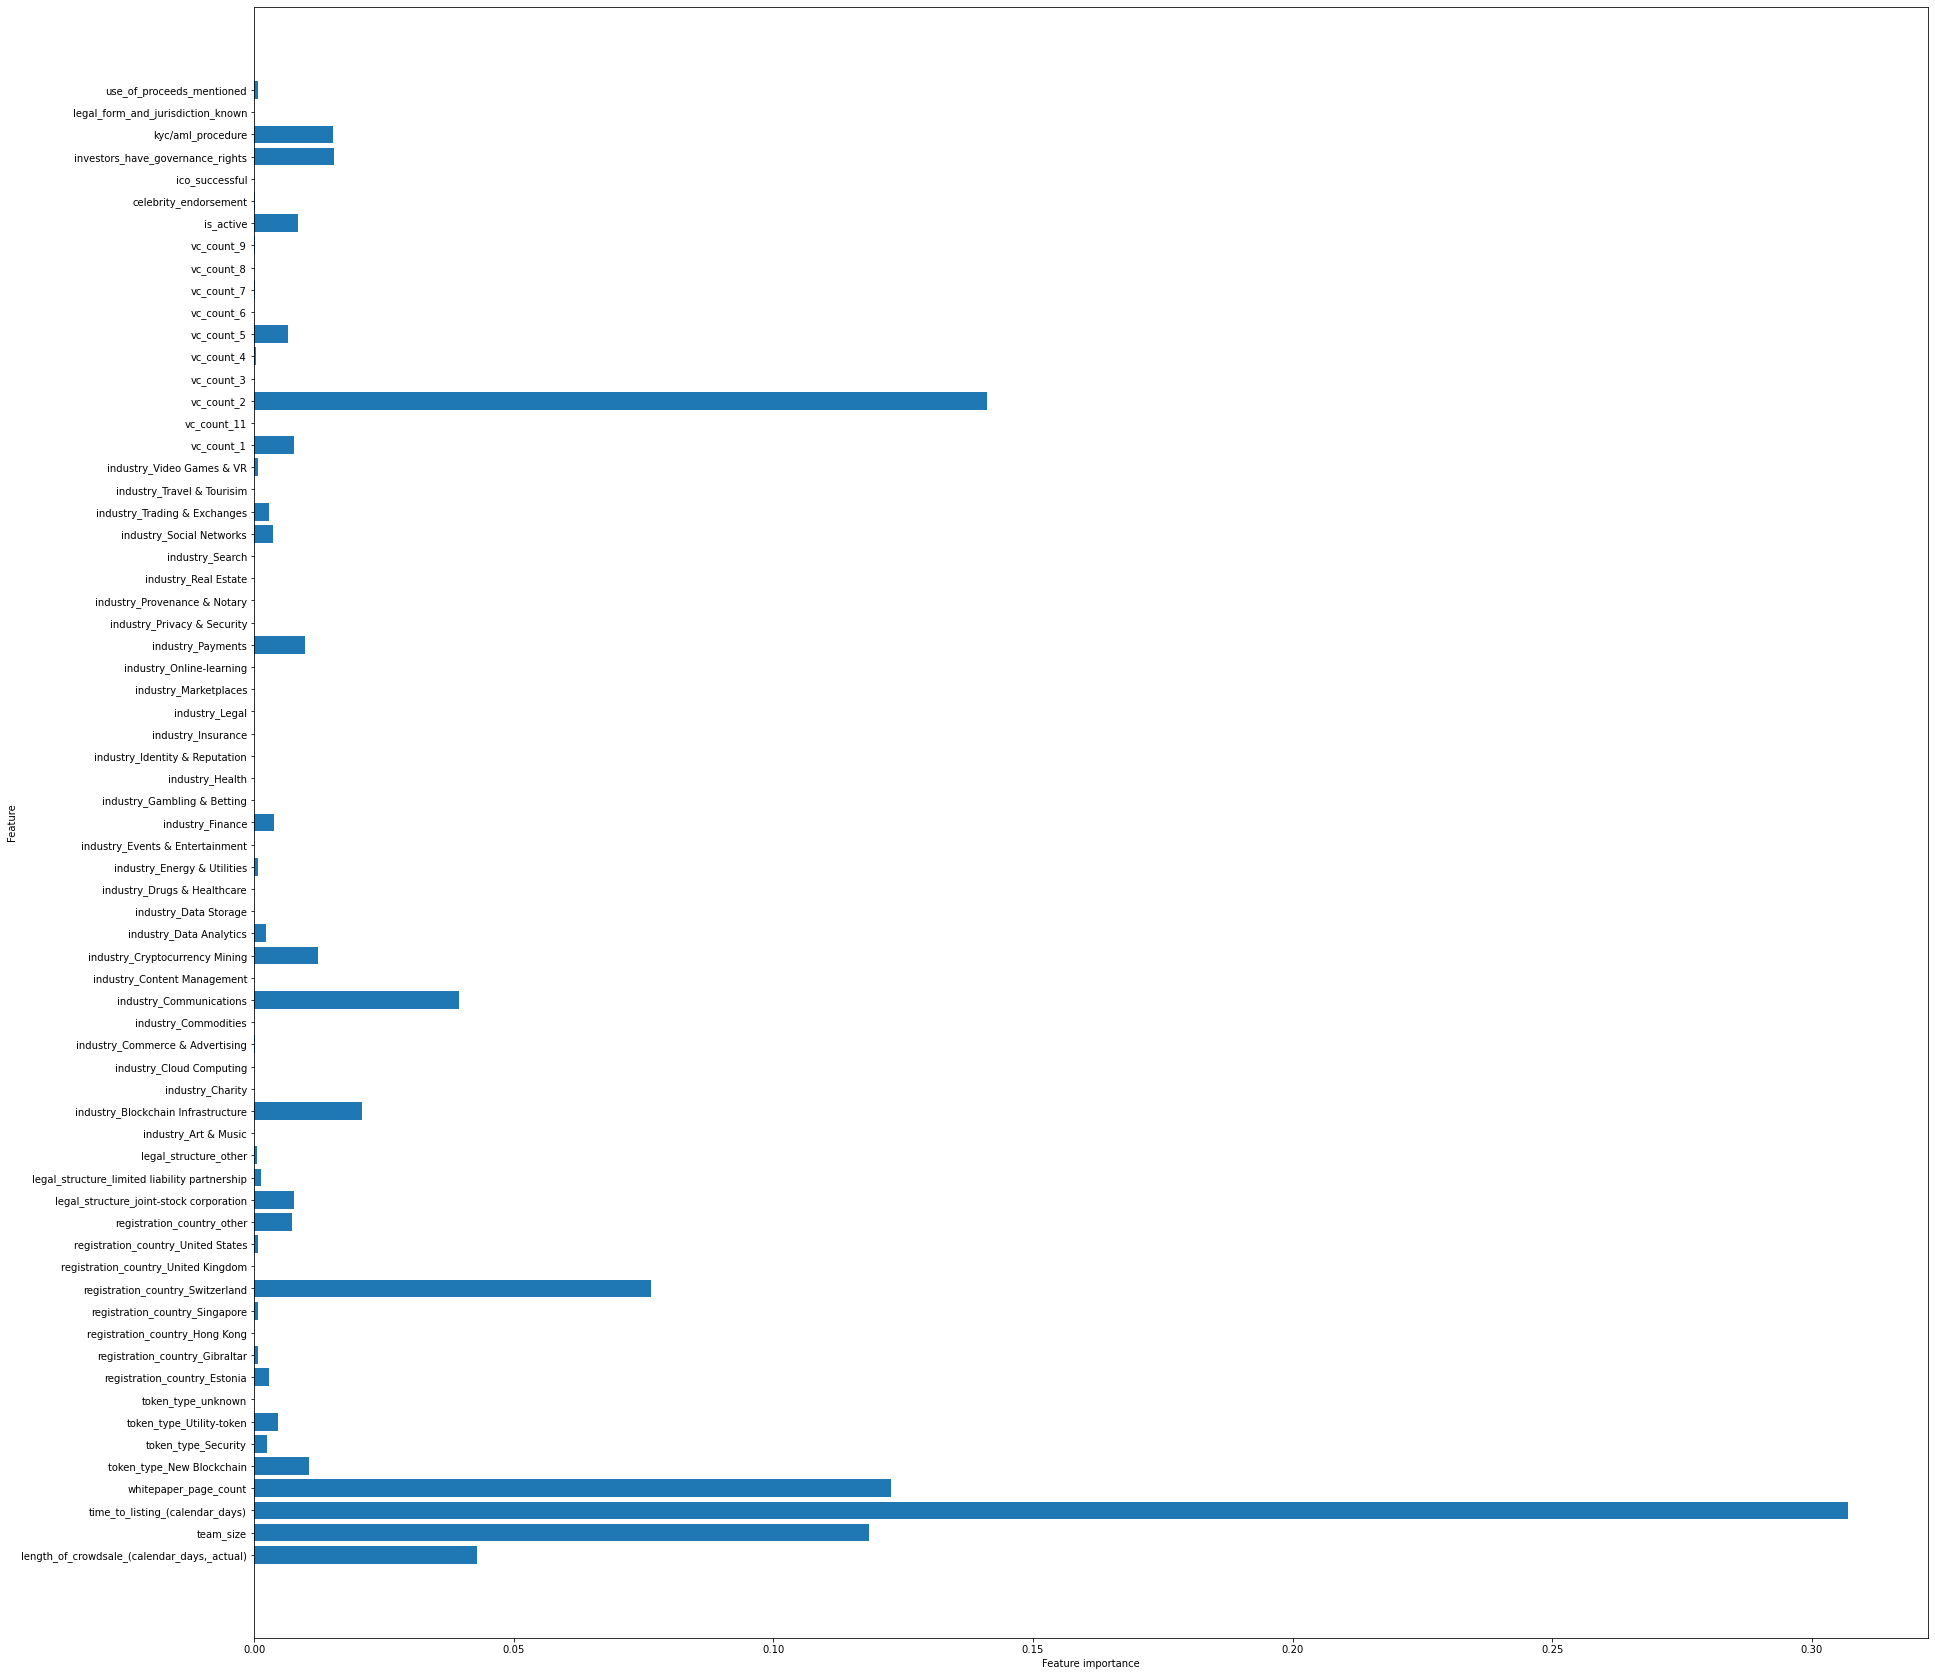

In [59]:
# Again looking at best features, this time with a Random Forest regression. Some interesting results but not worth including in discussion.

def plot_feature_importances_cancer(regr):
    n_features = X_clean.shape[1]
    plt.figure(figsize=(30,30))
    plt.barh(range(n_features), RFR_2.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_clean.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    

plot_feature_importances_cancer(RFR_2)

In [60]:
best_features = list(RFR_2.feature_importances_[RFR_2.feature_importances_>0.10])

best_features

[0.11837817898127076,
 0.30705152341984265,
 0.12268968801378573,
 0.14120886919462916]

In [67]:
feature_names=list(X_clean.columns)

In [ ]:
pred_rfr = RFR.predict(X_clean)